In [1]:
import matplotlib.pyplot as plt
from math import log
import numpy as np
%matplotlib notebook 

## User Input

In [2]:
from fconcrete import Load, Node, Beam, SingleBeamElement #, helpers.integrate as integrate

In [8]:
class Material():
    """
    E - in MPA
    Poisson - 
    """    
    def __init__(self, E, poisson, alpha):
        self.E = E
        self.poisson = poisson
        self.alpha = alpha
        
class Concrete(Material):
    def __init__(self, fck, aggressiveness, aggregate="granito"):
        
        alpha_e = 0
        if aggregate in ["basalto", "diabásio"]: alpha_e = 1.2
        if aggregate in ["granito", "gnaisse"]: alpha_e = 1
        if aggregate in ["calcário"]: alpha_e = 0.9
        if aggregate in ["arenito"]: alpha_e = 0.7
        if alpha_e == 0: raise Exception("Must select a valid aggregate: basalto, diabásio, granito, gnaisse, calcário ou arenito")
        
        if fck<20 or fck>90: raise Exception("Must select a valid fck value (between 20MPa and 90MPa)")
        if (fck>=20 and fck<=50): E_ci = alpha_e*5600*(fck**0.5)
        E_ci = alpha_e*21500*(fck/10+1.25)**(1/3) if fck>50 else E_ci
            
        fctm = 0.3*(fck**(2/3)) if fck<=50 else 2.12*log(1+0.11*fck)
        fctk_inf = 0.7*fctm
        fctk_sup = 1.3*fctm
        fctd = fck/1.4

        self.c = 1 if aggressiveness==1 else 2 if aggressiveness==2 else 3 if aggressiveness==3 else 4 if aggressiveness==4 else 0
        if self.c==0: raise Exception("Must select a valid fck value (between 1 and 4)")
    
        
        super(Concrete, self ).__init__(E_ci, 0.2, 10**(-5))
        
        self.fck = fck
        self.E_ci = E_ci
        self.fctm = fctm
        self.fctk_inf = fctk_inf
        self.fctk_sup = fctk_sup
        self.fctd = fctd
        


class Section():
    """
    Class to represent simetrical section along the y axis.
    function_width is made to define the width along the y axis. The function starts with x=0 and ends in x=height.
    height is to represent the maximum y value possible.
    """    
    def __init__(self, function_width, height, material):
        self.material = material
        self.height = height
        self.function_width = function_width
        self.area = self.getAreaBetween(0, height, 1000)
        self.I = self._I()
        self.d = height - material.c
        
    def width(self, height):
        return 0 if height>self.height else self.function_width(height)
    
    def getAreaBetween(self, begin_height, end_height, interations=100):
        return 2*integrate(self.function_width, begin_height, end_height, interations)
    
    def _I(self):
        raise NotImplmentedError
        return
        
    def plot(self, N=100):
        height = self.height
        x = np.linspace(0, height, N)
        y = np.array([self.function_width(xi) for xi in x])
        return plt.plot(y,x, -y, x)
    
    
class Rectangle(Section):
    def __init__(self,width, height, material):
        self.material = material
        self.__width = width
        self.height = height
        self.function_width = lambda x:width/2
        self.area = width*height
        self.I = self.width()*self.height**3/12
        
    def getAreaBetween(self, begin_height, end_height):
        return self.width()*(end_height - begin_height)
    
    def width(self, height=0):
        return self.__width
    

        

In [14]:
material = Concrete(fck=30, aggressiveness=3)
section = Rectangle(10,20, material)

f1 = Load.PontualLoad(-16, x=6)
f4 = Load.UniformDistributedLoad(-8, x_begin=0, x_end=4)

n1 = Node.SimpleSupport(x=0)
n2 = Node.SimpleSupport(x=4)
n3 = Node.MiddleNode(x=6)

bar1 = SingleBeamElement([n1, n2], section)
bar2 = SingleBeamElement([n2, n3], section)

beam = Beam(
    loads = [f1, f4],
    bars = [bar1, bar2]
)

self = beam

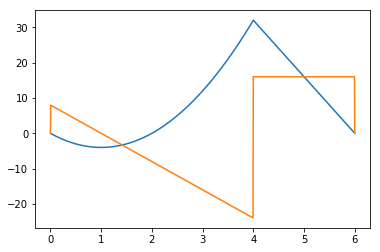

In [15]:
x, y = beam.getMomentumDiagram()
plt.plot(x, y)
x, y = beam.getShearDiagram()
plt.plot(x, y)